<a href="https://colab.research.google.com/github/GerardoGbb/TelecomXll/blob/main/Telecom_ll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 1. Carga de Datos ---
DataFrame 'telecom_churn_clean.csv' cargado. Dimensiones iniciales: (7267, 21)

--- 2. Preprocesamiento de Datos (Limpieza y Estandarización) ---
Dimensiones tras limpieza: (7043, 21)

--- 3. Preparando Datos para el Modelo ---
Conteo de clases en la variable objetivo antes del balanceo:
Churn
0    5174
1    1869
Name: count, dtype: int64
La clase minoritaria (Churn=1) representa el 26.54% de los datos.
Características identificadas: 4 numéricas y 16 categóricas.
Datos divididos en 5634 para entrenamiento y 1409 para prueba.

--- 4. Entrenando, Evaluando y Optimizando Modelos con Balanceo (SMOTE) ---

Optimizando Logistic Regression con SMOTE...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  Mejores parámetros para Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l1', 'smote__sampling_strategy': 0.7}
  Mejor ROC AUC de CV para Logistic Regression: 0.8441

--- Métricas para Optimizada con SMOTE - Logistic Regression ---
  Accura

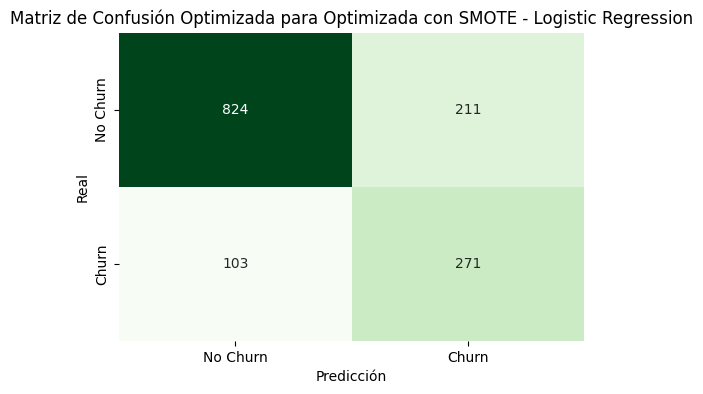


Optimizando Random Forest con SMOTE...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  Mejores parámetros para Random Forest: {'classifier__max_depth': 10, 'classifier__n_estimators': 200, 'smote__sampling_strategy': 0.7}
  Mejor ROC AUC de CV para Random Forest: 0.8392

--- Métricas para Optimizada con SMOTE - Random Forest ---
  Accuracy:  0.7807 | Precision: 0.5799 | Recall: 0.6310 | F1-Score: 0.6044 | ROC-AUC: 0.8406
Matriz de Confusión:
 [[864 171]
 [138 236]]


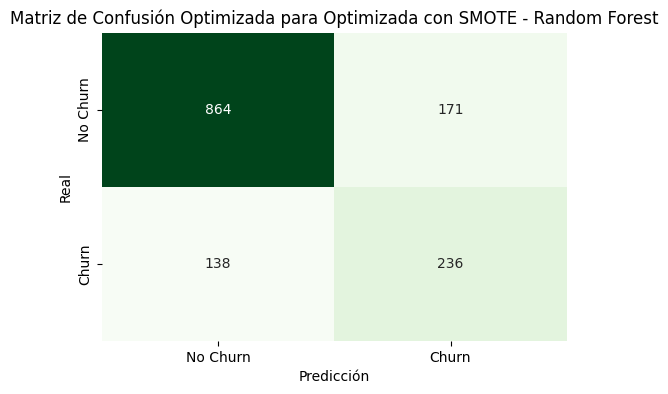


--- Optimización de modelos con balanceo completada ---

--- 5. Guardando el Modelo Ganador ---
🏆 Modelo ganador: 'Logistic Regression' (ROC-AUC: 0.8412).
✅ Pipeline del modelo ganador (incluyendo preprocesador y SMOTE) guardado exitosamente como 'modelo\mejor_modelo_churn_balanceado.joblib'

--- 6. Interpretación de Resultados: Importancia de las Variables (Modelos Optimizados con SMOTE) ---


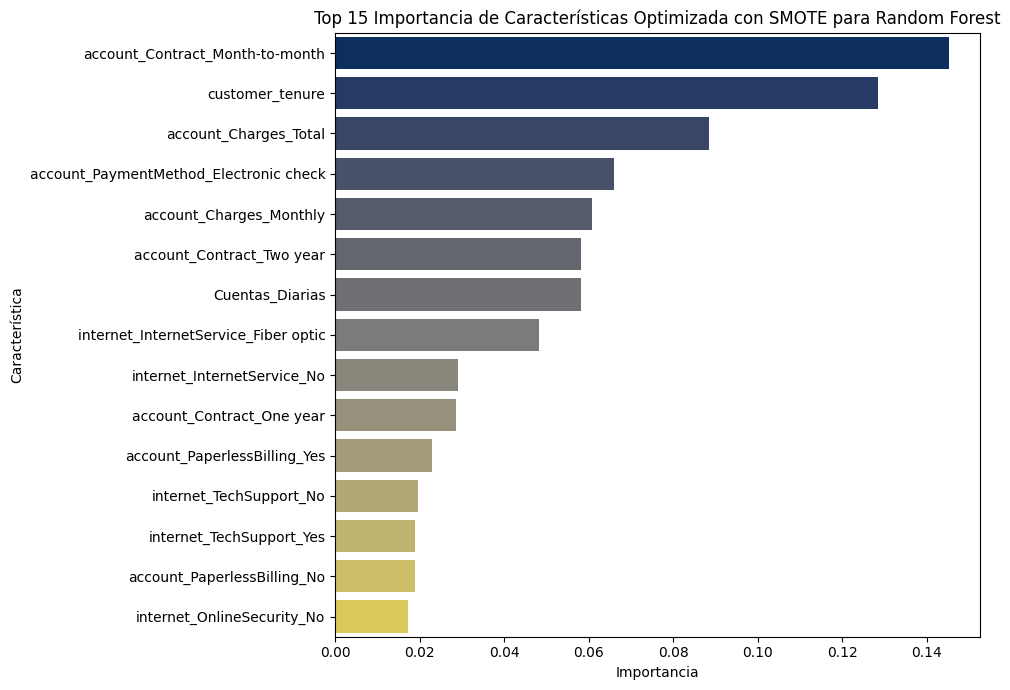

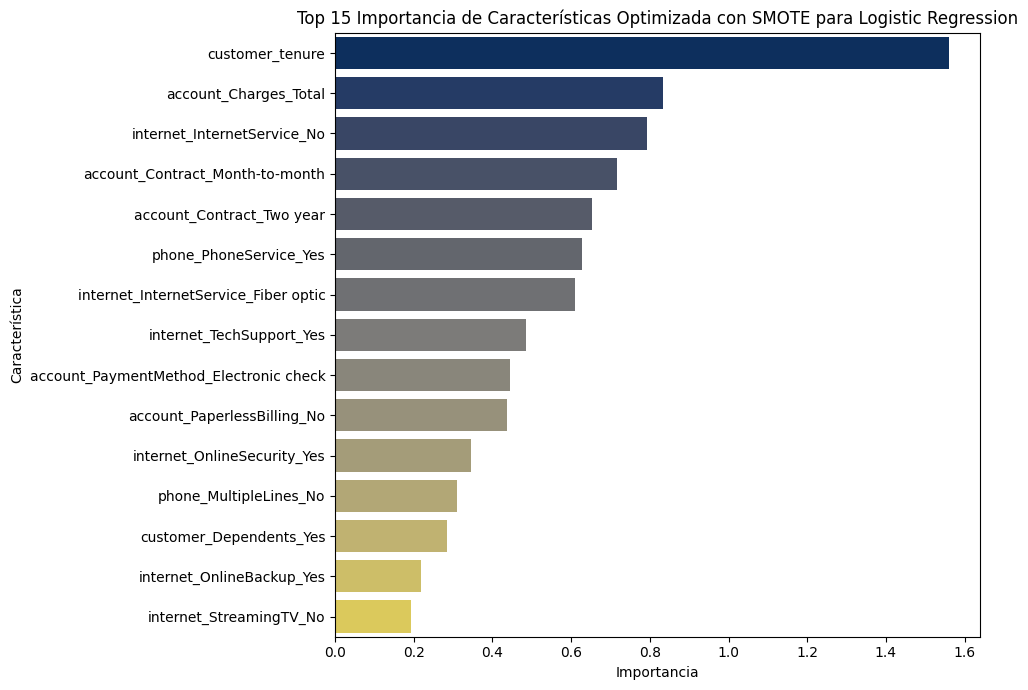

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import joblib
import warnings

# Importar SMOTE y Pipeline de imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Ignorar advertencias para una salida más limpia
warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. Carga de Datos ---
print("--- 1. Carga de Datos ---")
try:
    file_path = 'telecom_churn_clean.csv'
    # Ajuste de la ruta del archivo para el entorno de ejecución
    # Si el archivo está en la misma carpeta que el script, simplemente 'telecom_churn_clean.csv'
    # Si está en una subcarpeta 'datos', la ruta es 'datos/telecom_churn_clean.csv'
    # Asegurémonos de que la ruta sea compatible con Linux/macOS también, usando '/'
    file_path_adjusted = 'telecom_churn_clean.csv' # Asumimos que está en el directorio actual tras subirlo
    df = pd.read_csv(file_path_adjusted)
    print(f"DataFrame '{file_path_adjusted}' cargado. Dimensiones iniciales: {df.shape}")
except FileNotFoundError:
    print(f"Error Crítico: El archivo '{file_path_adjusted}' no se encontró. Asegúrate de que esté en la ruta correcta.")
    raise

# --- 2. Preprocesamiento de Datos (Limpieza y Estandarización) ---
print("\n--- 2. Preprocesamiento de Datos (Limpieza y Estandarización) ---")

df.columns = [col.replace('.', '_').strip() for col in df.columns]

# Manejo de nulos en 'Churn' y conversión a int
df.dropna(subset=['Churn'], inplace=True)
df['Churn'] = df['Churn'].astype(int)

# Manejo de nulos en 'account_Charges_Total' y conversión a numérico
df['account_Charges_Total'] = pd.to_numeric(df['account_Charges_Total'], errors='coerce')
df['account_Charges_Total'].fillna(df['account_Charges_Total'].median(), inplace=True)

# Normalizar valores de servicio a 'No'/'Yes'
cols_to_normalize_service = [
    'phone_MultipleLines', 'internet_OnlineSecurity', 'internet_OnlineBackup',
    'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies']
for col in cols_to_normalize_service:
    if col in df.columns:
        df[col] = df[col].replace({'No phone service': 'No', 'No internet service': 'No'})

# Convertir 'customer_SeniorCitizen' a 'No'/'Yes'
df['customer_SeniorCitizen'] = df['customer_SeniorCitizen'].map({0: 'No', 1: 'Yes'})


print(f"Dimensiones tras limpieza: {df.shape}")

# --- 3. Preparación de Datos para el Modelo (Separación y Transformación) ---
print("\n--- 3. Preparando Datos para el Modelo ---")
X = df.drop('Churn', axis=1)
y = df['Churn']

# Imprimir el conteo de clases antes del balanceo para ver el desbalanceo inicial
print(f"Conteo de clases en la variable objetivo antes del balanceo:\n{y.value_counts()}")
minority_class_percentage = (y.value_counts()[1] / len(y)) * 100
print(f"La clase minoritaria (Churn=1) representa el {minority_class_percentage:.2f}% de los datos.")


# Identificar tipos de características
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns
print(f"Características identificadas: {len(numerical_features)} numéricas y {len(categorical_features)} categóricas.")

# Crear el preprocesador (Escalado y One-Hot Encoding)
preprocessor_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Dividir los datos en entrenamiento y prueba (antes de SMOTE para evitar fuga de datos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Datos divididos en {len(X_train)} para entrenamiento y {len(X_test)} para prueba.")


# --- 4. Entrenamiento, Evaluación y Optimización de Modelos con Balanceo (SMOTE) ---
print("\n--- 4. Entrenando, Evaluando y Optimizando Modelos con Balanceo (SMOTE) ---")

models_and_params = {
    "Logistic Regression": {
        'model': LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2'],
            'smote__sampling_strategy': [0.7, 1.0] # Probar con diferentes ratios de SMOTE
        }
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
            'smote__sampling_strategy': [0.7, 1.0]
        }
    }
    # LightGBM ha sido excluido aquí debido a la limitación de la librería en el entorno
    # Si lo deseas incluir, asegúrate de tener 'lightgbm' instalado
    # "LightGBM": {
    #     'model': lgb.LGBMClassifier(random_state=42),
    #     'params': {
    #         'classifier__n_estimators': [100, 200],
    #         'classifier__learning_rate': [0.05, 0.1],
    #         'classifier__num_leaves': [20, 31],
    #         'smote__sampling_strategy': [0.7, 1.0]
    #     }
    # }
}

optimized_models = {}
model_performance = {} # Para almacenar ROC AUC en el conjunto de prueba

cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Usar 3 folds para rapidez en tuning

def evaluate_model(name, model_pipeline, X_test_data, y_test_data):
    """Calculates and displays model metrics for a given pipeline."""
    y_pred = model_pipeline.predict(X_test_data)
    y_proba = model_pipeline.predict_proba(X_test_data)[:, 1]

    precision = precision_score(y_test_data, y_pred, zero_division=0)
    recall = recall_score(y_test_data, y_pred, zero_division=0)
    f1 = f1_score(y_test_data, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test_data, y_proba)
    accuracy = accuracy_score(y_test_data, y_pred)

    print(f"\n--- Métricas para {name} ---")
    print(f"  Accuracy:  {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")

    cm = confusion_matrix(y_test_data, y_pred)
    print("Matriz de Confusión:\n", cm)

    # Visualizar la Matriz de Confusión del modelo optimizado
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title(f'Matriz de Confusión Optimizada para {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    # Crear carpeta 'img' si no existe
    import os
    if not os.path.exists('img'):
        os.makedirs('img')
    plt.savefig(f'img\\optimized_confusion_matrix_{name.replace(" ", "_")}_smote.png') # Añadido '_smote'
    plt.show()

    return roc_auc

for name, mp in models_and_params.items():
    print(f"\nOptimizando {name} con SMOTE...")

    # Crear un pipeline que incluya preprocesamiento, SMOTE y el clasificador
    pipeline_with_smote = ImbPipeline(steps=[
        ('preprocessor', preprocessor_transformer), # Usar el transformer definido
        ('smote', SMOTE(random_state=42)),
        ('classifier', mp['model'])
    ])

    grid_search = GridSearchCV(pipeline_with_smote, mp['params'], cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=1)
    # X_train y y_train se pasan al grid_search; SMOTE se aplica dentro del pipeline en cada fold de CV.
    grid_search.fit(X_train, y_train)

    optimized_models[name] = grid_search.best_estimator_
    print(f"  Mejores parámetros para {name}: {grid_search.best_params_}")
    print(f"  Mejor ROC AUC de CV para {name}: {grid_search.best_score_:.4f}")

    # Evaluar el mejor estimador directamente en X_test (sin SMOTE, que solo aplica en train)
    auc_score = evaluate_model(f"Optimizada con SMOTE - {name}", grid_search.best_estimator_, X_test, y_test)
    model_performance[name] = auc_score

print("\n--- Optimización de modelos con balanceo completada ---")

# --- 5. Almacenamiento del Modelo Ganador ---
print("\n--- 5. Guardando el Modelo Ganador ---")

if model_performance:
    best_model_name = max(model_performance, key=model_performance.get)
    best_model_pipeline = optimized_models[best_model_name]
    best_model_score = model_performance[best_model_name]

    print(f"🏆 Modelo ganador: '{best_model_name}' (ROC-AUC: {best_model_score:.4f}).")

    model_filename = 'modelo\\mejor_modelo_churn_balanceado.joblib'
    joblib.dump(best_model_pipeline, model_filename)
    print(f"✅ Pipeline del modelo ganador (incluyendo preprocesador y SMOTE) guardado exitosamente como '{model_filename}'")
else:
    print("❌ No se pudo determinar un modelo ganador.")


# --- 6. Interpretación de Resultados: Importancia de las Variables (Modelos Optimizados con SMOTE) ---
print("\n--- 6. Interpretación de Resultados: Importancia de las Variables (Modelos Optimizados con SMOTE) ---")

# Para obtener los nombres de características finales, necesitamos el preprocesador del pipeline
# y el X_train original (o X_processed_df.columns si ya está listo)
# Asegurarse de que X_processed_df esté disponible antes de este punto
# Si no está definido, recalcularlo aquí (ya se hace al inicio del script)
# feature_names_list = X_processed_df.columns.tolist()

def plot_optimized_feature_importance(model_pipeline, raw_X_data_for_ohe_names, numerical_features, categorical_features, model_name, top_n=15):
    # Obtener el preprocesador del pipeline
    preprocessor_pipeline_step = model_pipeline.named_steps['preprocessor']

    # Obtener los nombres de las características después del OneHotEncoder
    ohe_names = preprocessor_pipeline_step.named_transformers_['cat'].get_feature_names_out(categorical_features)

    # Combinar nombres de características numéricas y codificadas
    full_feature_names = list(numerical_features) + list(ohe_names)

    # El clasificador real está dentro del pipeline
    classifier = model_pipeline.named_steps['classifier']

    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
    elif hasattr(classifier, 'coef_'):
        # Coeficientes para Regresión Logística
        importances = np.abs(classifier.coef_[0])
    else:
        print(f"El clasificador del pipeline '{model_name}' no tiene atributo de importancia de características o coeficientes.")
        return

    feature_importance_df = pd.DataFrame({'Feature': full_feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 7))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='cividis')
    plt.title(f'Top {top_n} Importancia de Características Optimizada con SMOTE para {model_name}')
    plt.xlabel('Importancia')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.savefig(f'img\\optimized_feature_importance_{name.replace(" ", "_")}_smote.png') # Añadido '_smote'
    plt.show()

# Ejecutar la visualización de importancia de características para los modelos optimizados con SMOTE
if "Random Forest" in optimized_models:
    plot_optimized_feature_importance(optimized_models["Random Forest"], X_train, numerical_features, categorical_features, "Random Forest")
# LightGBM ha sido excluido en este código
# if "LightGBM" in optimized_models:
#    plot_optimized_feature_importance(optimized_models["LightGBM"], X_train, numerical_features, categorical_features, "LightGBM")
if "Logistic Regression" in optimized_models:
    plot_optimized_feature_importance(optimized_models["Logistic Regression"], X_train, numerical_features, categorical_features, "Logistic Regression")